Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.7.3
IPython 7.9.0

torch 1.4.0


- Runs on CPU or GPU (if available)

# Vanilla Loss Gradient (wrt Inputs) Visualization 

## (Based on a VGG16 Convolutional Neural Network for Kaggle's Cats and Dogs Images)

Vizualization of the loss gradients with respect to the inputs (images) as a naive way to visualize CNN predictions. I.e.,

$$\nabla L(\mathbf{x})=  \left[\begin{array}{c}
\frac{\partial L}{\partial x_1} \\
\frac{\partial L}{\partial x_2} \\
\vdots
\end{array}\right]$$

Please note that this notebook is to be run after [./_cnn-basemodel__vgg16-cats-dogs.ipynb](_cnn-basemodel__vgg16-cats-dogs.ipynb), which trains the VGG16 model on thh cats and dogs dataset.

## Imports

In [2]:
import time
import os

import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn


from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

from PIL import Image
import matplotlib.pyplot as plt


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [3]:
%matplotlib inline

## Settings

In [4]:
##########################
### SETTINGS
##########################

# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
RANDOM_SEED = 1
BATCH_SIZE = 128

# Architecture
NUM_CLASSES = 2

# Image normalization parameters from _cnn-basemodel__vgg16-cats-dogs.ipynb
train_mean = [0.4875, 0.4544, 0.4164]
train_std = [0.2521, 0.2453, 0.2481]

## Cats vs Dogs Dataset

Please see [_cnn-basemodel__vgg16-cats-dogs.ipynb](_cnn-basemodel__vgg16-cats-dogs.ipynb) for instructions with regard to downloading this dataset.

(331, 464, 3)


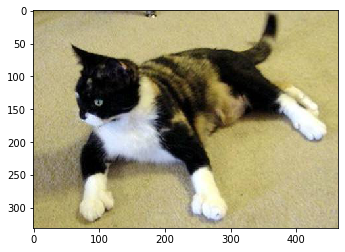

In [5]:
img = Image.open(os.path.join('dogs-vs-cats','train', 'cat.59.jpg'))
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

In [6]:
class CatsDogsDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, img_dir, transform=None):
    
        self.img_dir = img_dir
        
        self.img_names = [i for i in 
                          os.listdir(img_dir) 
                          if i.endswith('.jpg')]
        
        self.y = []
        for i in self.img_names:
            if i.split('.')[0] == 'cat':
                self.y.append(0)
            else:
                self.y.append(1)
        
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return len(self.y)

### Dataloaders

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(64, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize([64, 64]),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ]),
}


train_dataset = CatsDogsDataset(img_dir=os.path.join('dogs-vs-cats', 'train'), 
                                transform=data_transforms['train'])

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          shuffle=True)

valid_dataset = CatsDogsDataset(img_dir=os.path.join('dogs-vs-cats', 'valid'), 
                                transform=data_transforms['valid'])

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

test_dataset = CatsDogsDataset(img_dir=os.path.join('dogs-vs-cats', 'test'), 
                               transform=data_transforms['valid'])

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

## Model

In [8]:
from vgg16 import VGG16

In [9]:
torch.manual_seed(RANDOM_SEED)
model = VGG16(num_classes=NUM_CLASSES)
model = model.to(DEVICE)

model.load_state_dict(torch.load('vgg16-cats-dogs.state_dict'))

<All keys matched successfully>

## Gradient Visualization

In [10]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
unorm = UnNormalize(mean=train_mean, std=train_std)

In [11]:
model.eval()
test_loader = DataLoader(dataset=train_dataset, 
                         batch_size=1, 
                         shuffle=True)

for features, targets in test_loader:
    break
    
features = features.to(DEVICE)
targets = targets.to(DEVICE)

### Save input gradient
features.requires_grad = True

### FORWARD AND BACK PROP
logits, probas = model(features)
cost = F.cross_entropy(logits, targets)
cost.backward()

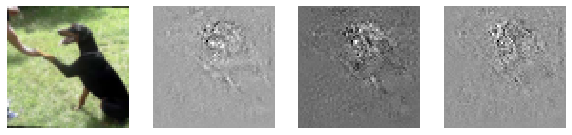

In [12]:
gradient = features.grad[0]
#gradient = gradient - gradient.min()
#gradient /= gradient.max()

fig, ax = plt.subplots(1, 4, figsize=(10, 5))

# plot images
img = unorm(features[0].detach().cpu())
ax[0].imshow(np.transpose(img, (1, 2, 0)))
ax[0].axis('off')

# plot loss gradient with respect to input
for i in range(0, 3):
    img = gradient[i].cpu()
    ax[i+1].imshow(img, cmap='gray')
    ax[i+1].axis('off')
    
plt.show()

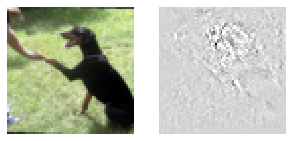

In [13]:
gradient = gradient - gradient.min()
gradient /= gradient.max()


def convert_to_grayscale(im_as_arr):
    """
    Converts RGB image to grayscale
    Expects and returns CHW format.
    """
    grayscale_im = np.sum(np.abs(im_as_arr), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im


fig, ax = plt.subplots(1, 2, figsize=(5, 10))

# plot images
img = unorm(features[0].detach().cpu())
ax[0].imshow(np.transpose(img, (1, 2, 0)))
ax[0].axis('off')

# plot loss gradient with respect to input
img = convert_to_grayscale(gradient.cpu().numpy())
ax[1].imshow(np.transpose(img, (1, 2, 0))[:, :, 0], cmap='gray')
ax[1].axis('off')

plt.show()

In [14]:
from PIL import Image

grad_img = np.uint8(np.transpose(gradient.cpu()*255.0, (1, 2, 0)))

result = Image.fromarray(grad_img)
result.save('gradient.png')

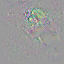

In [15]:
from IPython.display import display
display(result)